# This notebook intends to find approaches for data preprocessing in order to create a dataset for a low-weight trial CNN-model
1. Find a filter to be applied to the original sized image to improve texture
2. Apply rezised mask to the filtered image -> Region of interest (lung area is exposed only) 
3. Downscale the masked images by different factors
4. Calculate metrics and save them as csv
5. Compare them to the original sized masked images and conclude

## 1. Find a filter to be applied to the original sized image to improve 

* For a 299x299 grayscale X-ray image, the parameters for method 5 (Non-Local Means Denoising + CLAHE) should be carefully selected to preserve important details while removing noise. Here's what I recommend:

  * Non-Local Means Denoising Parameters
  
    h: 10-30 (Higher values remove more noise but risk blurring details. Start with 30 for heavy noise or 15 for mild noise.)
    templateWindowSize: 7 (Default value works well for small images like 299x299.)
    searchWindowSize: 21 (Larger window sizes improve noise reduction but increase computation time. Use 21 for this resolution.)

  * CLAHE Parameters

    clipLimit: 2.0-3.0 (This enhances contrast without over-amplifying noise.)
    tileGridSize: (8, 8) or (16, 16) (A smaller tile size like (8, 8) ensures contrast adjustments are applied locally, suitable for medical images.)


Here is the result of enhancing the X-ray image using Denoising with Non-Local Means combined with CLAHE (Contrast Limited Adaptive Histogram Equalization) with OpenCV. 

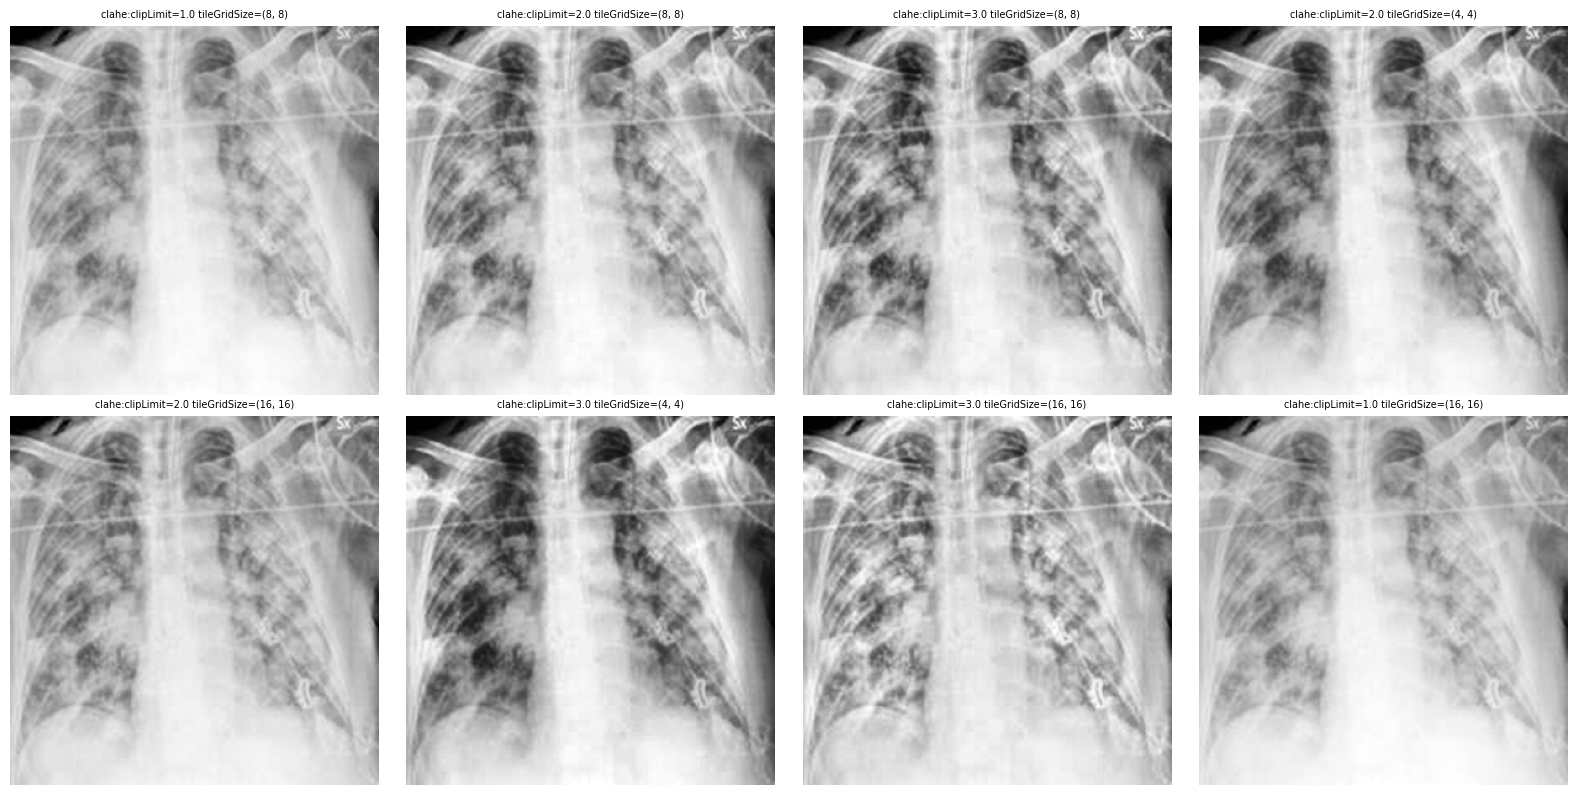

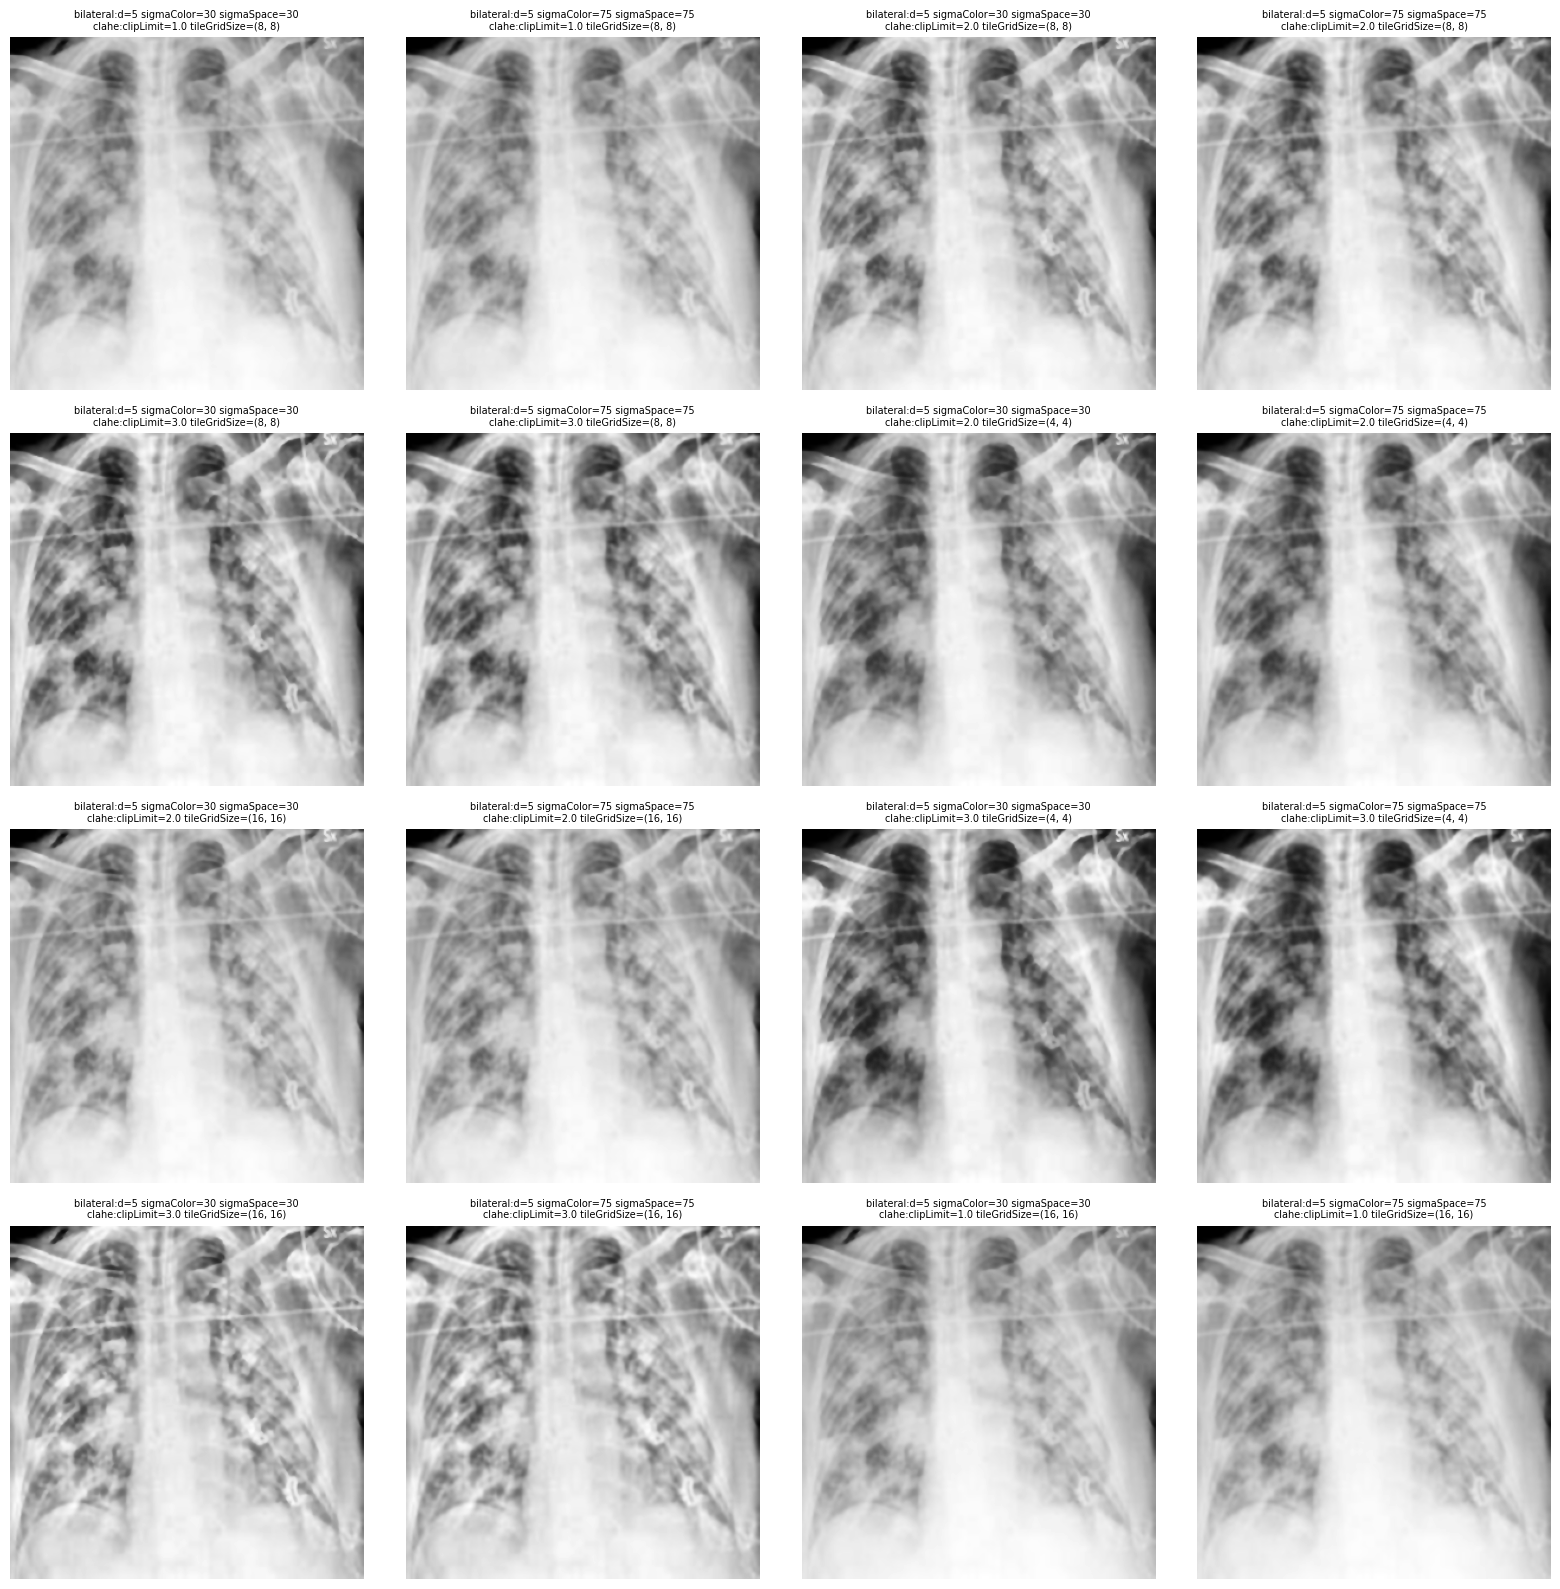

In [61]:
import importlib
import src.utils.img_processing
importlib.reload(src.utils.img_processing)  # Reload the module
from src.utils.img_processing import ImageProcessor

ip = ImageProcessor()

# Define parameter sets for CLAHE
parameter_sets_clahe = [
    {"clipLimit": 1.0, "tileGridSize": (8, 8)},
    {"clipLimit": 2.0, "tileGridSize": (8, 8)},
    {"clipLimit": 3.0, "tileGridSize": (8, 8)},
    {"clipLimit": 2.0, "tileGridSize": (4, 4)},
    {"clipLimit": 2.0, "tileGridSize": (16, 16)},
    {"clipLimit": 3.0, "tileGridSize": (4, 4)},
    {"clipLimit": 3.0, "tileGridSize": (16, 16)},
    {"clipLimit": 1.0, "tileGridSize": (16, 16)},
]
# Define a set of recommended parameter combinations for bilateral filtering
parameter_sets_bilateral = [
    {"d": 5, "sigmaColor": 30, "sigmaSpace": 30},
    {"d": 5, "sigmaColor": 75, "sigmaSpace": 75},
    # {"d": 9, "sigmaColor": 30, "sigmaSpace": 30},
    # {"d": 9, "sigmaColor": 75, "sigmaSpace": 75},
    # {"d": 15, "sigmaColor": 30, "sigmaSpace": 30},
    # {"d": 15, "sigmaColor": 75, "sigmaSpace": 75},
    # {"d": 9, "sigmaColor": 50, "sigmaSpace": 50},
    # {"d": 9, "sigmaColor": 100, "sigmaSpace": 100},
]


clahe_images, titles = ip.applyFilter([xray_image_cv2], formerTitles=None, filterSelector="clahe", paramSets=parameter_sets_clahe, plotResult=True)
#bilat_images, _ = ip.applyFilter([xray_image_cv2], filterSelector="bilateral", paramSets=parameter_sets_bilateral, plotResult=True)

clahe_bilat, _ = ip.applyFilter(clahe_images, formerTitles=titles, filterSelector="bilateral", paramSets=parameter_sets_bilateral, plotResult=True)
#bilat_clahe, _ = ip.applyFilter(bilat_images, filterSelector="clahe", paramSets=parameter_sets_clahe, plotResult=True)

In [54]:
len(clahe_images), len(titles)
    

(8, 64)

## 2. Creating resized masked images
* resize mask to original image size 
* apply mask and save the resulted image with only lung region of interest (ROI)

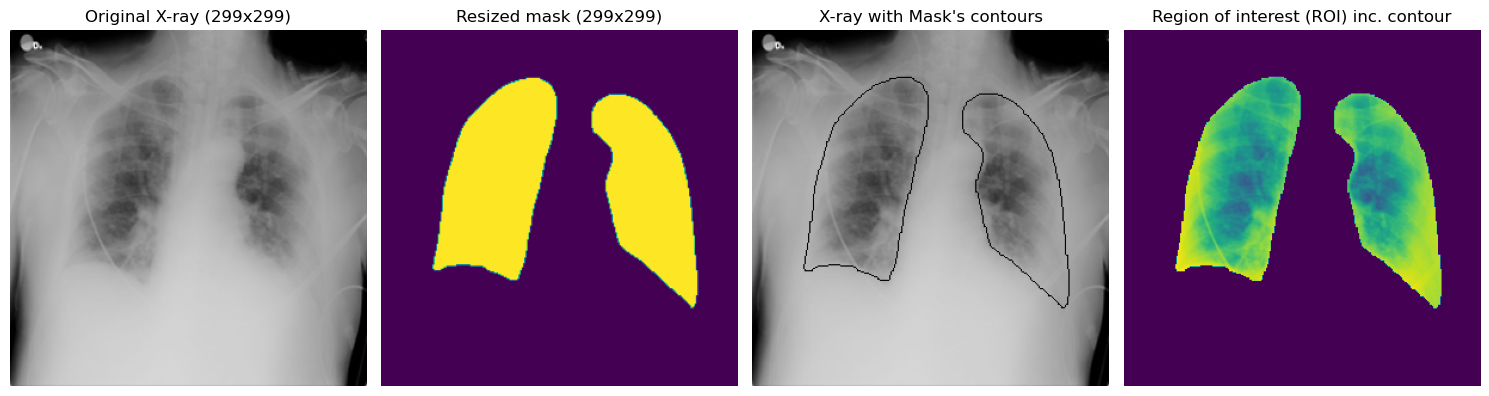

In [1]:
import importlib
import src.utils.img_processing
importlib.reload(src.utils.img_processing)  # Reload the module
from src.utils.img_processing import ImageProcessor

import cv2
import matplotlib.pyplot as plt

# Load the original X-ray image and mask
xray_path = r"D:\DataScience\area51\data\COVID-19_Radiography_Dataset\COVID\images\COVID-1.png"
mask_path = r"D:\DataScience\area51\data\COVID-19_Radiography_Dataset\COVID\masks\mCOVID-1.png"

xray_image = cv2.imread(xray_path, cv2.IMREAD_GRAYSCALE)
mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

ip = ImageProcessor()
masked_resized = ip.getRoiWithResizedMask(img=xray_image, mask=mask_image, plotResult=True)

In [4]:
# checking the mask for values other than 255 (white/transparent)
import cv2

mask32 = cv2.resize(mask_image, (32,32))
print(mask32[mask32 > 0])

[128 255  64 191 255 255 255 255 128 255 255 255 255 255 255 255 191 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 191 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191
 255 255 255 255 255 128 191 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 128 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255  64 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255  64 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128
 191 255 255 255 255 255 255 255  64 255 255 255 25

## Downscaling the image
Best Interpolation for Downscaling X-ray Images

For medical images, preserving details is crucial. The best interpolation method is:

✅ cv2.INTER_AREA → Best for downscaling (avoids aliasing & preserves details).

This method averages pixel values, making it ideal for medical imaging where preserving structures is critical.

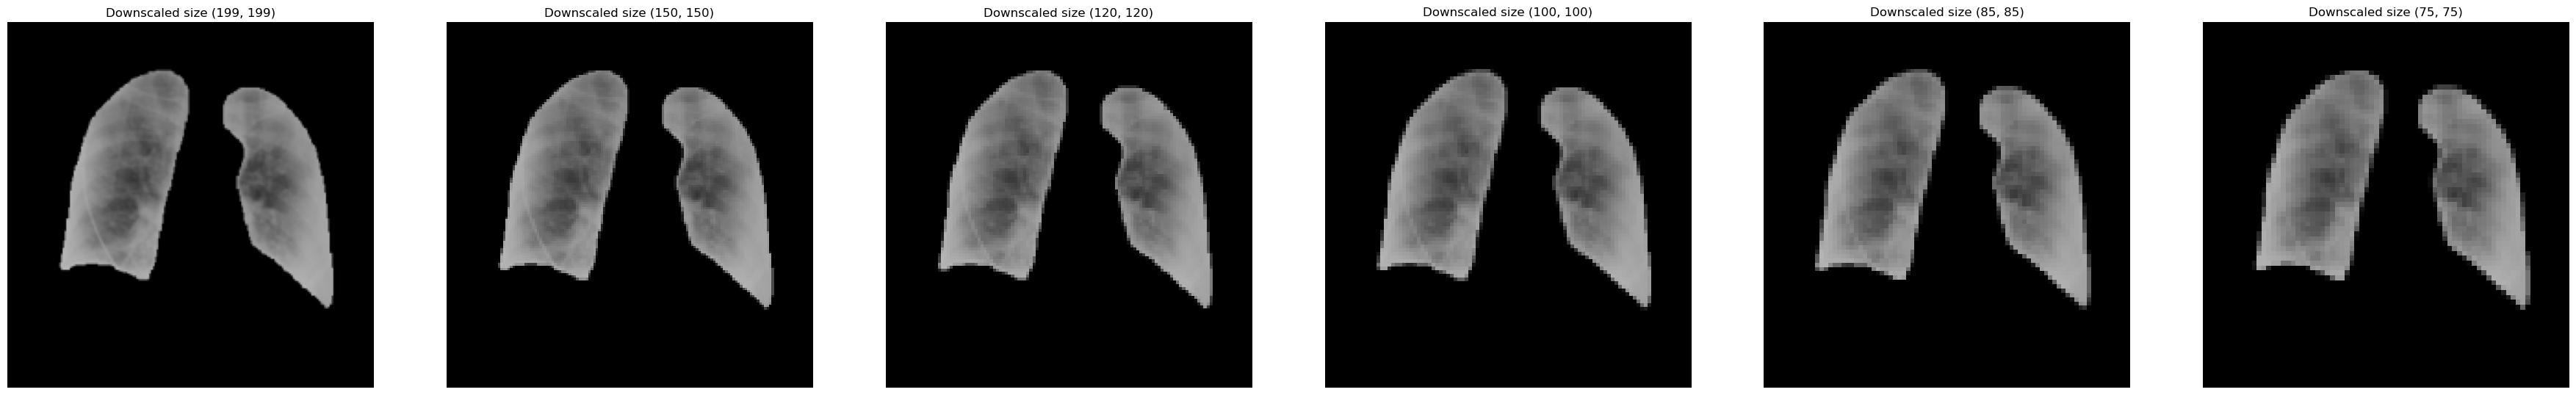

In [ ]:
import importlib
import src.utils.img_processing
importlib.reload(src.utils.img_processing)  # Reload the module
from src.utils.img_processing import ImageProcessor


downscaled_images = []

# down scaling factor
for dFact in ( 1.5, 2, 2.5, 3, 3.5, 4): 
    
    hDim = round(299 / dFact)
    wDim = hDim
    new_size = (hDim, wDim)

    downscaled_images.append(ip.downscale(masked_resized, new_size , interpolation=cv2.INTER_AREA, plotResult=False))


num_images = len(downscaled_images)
plt.figure(figsize=(45, 5*num_images))  # Adjust figure size

for i, img in enumerate(downscaled_images):
            
    plt.subplot(1, num_images, i + 1)  # Arrange images in a row
    plt.title(f"Downscaled size {img.shape[0], img.shape[0]}")
    plt.imshow(img, cmap='gray')  # Display grayscale image
    plt.axis("off")  # Hide axes

plt.show()  # Show images
        

#ip.dispImgs(downscaled_images)

# Create a mask for lung area using pretrained model

In [ ]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

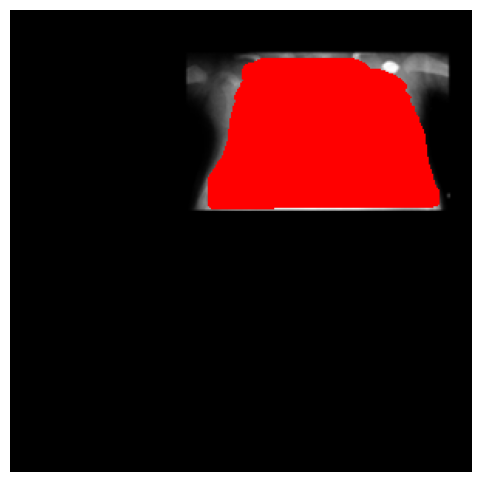

In [8]:
# Re-import necessary libraries due to execution state reset
import torch
import torchvision.transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is already loaded
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# model.eval()

# Load the X-ray image
image_path = r"D:\DataScience\area51\data\COVID-19_Radiography_Dataset\COVID\images\COVID-3615.png"
image = cv2.imread(image_path)

# Check if the image is loaded correctly
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to tensor
transform = T.Compose([T.ToPILImage(), T.ToTensor()])
image_tensor = transform(image_rgb).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Ensure there are detections
if len(predictions) > 0:
    prediction = predictions[0]  # Access the first item in the list

    # Extract masks and scores
    masks = prediction["masks"]
    scores = prediction["scores"]

    # Apply threshold to filter weak detections
    threshold = 0.5
    filtered_masks = [
        masks[i, 0].mul(255).byte().cpu().numpy()
        for i in range(len(scores))
        if scores[i] > threshold
    ]

    # Overlay masks on the original image
    overlay = image_rgb.copy()
    for mask in filtered_masks:
        overlay[mask > 128] = [255, 0, 0]  # Mark detected lung area in red

    # Show the result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

else:
    print("No objects detected.")


In [ ]:
import numpy as np
import cv2 # import OpenCV
import matplotlib.pyplot as plt
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')

# Load the original X-ray image and mask
covImg_path = r"D:\DataScience\area51\data\COVID-19_Radiography_Dataset\COVID\images\COVID-1.png"
img = cv2.imread(covImg_path, cv2.IMREAD_GRAYSCALE)

filter_gb = cv2.GaussianBlur(img,(3,3),0)
edges = cv2.Canny(filter_gb,100,200)

plt.figure(figsize = (15,20))

plt.subplot(1, 3, 1)  # Arrange images in a row
plt.imshow(img, cmap = 'gray')
plt.title(f"{covImg_path.split("\\")[-1]} {img.shape[0], img.shape[0]}")
plt.axis("off")  # Hide axes

plt.subplot(1, 3, 2)  # Arrange images in a row
plt.title(f"Lung area ")
plt.imshow(edges, cmap='gray')  # Display grayscale image
plt.xticks([])
plt.yticks([])


plt.show();

ModuleNotFoundError: No module named 'torch'